In [1]:
%pip install xgboost scikit-learn spacy numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import spacy
import spacy.cli
from sklearn.decomposition import TruncatedSVD  # type: ignore

SVD_EMBEDDING_DIM = 1

spacy.cli.download("en_core_web_md")  # type: ignore
nlp = spacy.load("en_core_web_md")


def embed_genres(data: pd.DataFrame) -> dict[str, np.ndarray]:
    unique_genres = data["track_genre"].dropna().unique()
    tokenized = pd.Series(unique_genres).str.lower().str.split().to_list()

    def avg_vector(tokens: list[str]) -> np.ndarray:
        vectors = [nlp.vocab[t].vector for t in tokens if nlp.vocab[t].has_vector]

        return (
            np.mean(vectors, axis=0) if vectors else np.zeros(nlp.vocab.vectors_length)  # type: ignore
        )

    vectors = np.vstack([avg_vector(tokens) for tokens in tokenized])
    svd_vectors = TruncatedSVD(n_components=SVD_EMBEDDING_DIM).fit_transform(vectors)  # type: ignore

    return {genre: svd_vectors[i] for i, genre in enumerate(unique_genres)}


def prepare_X(data: pd.DataFrame) -> pd.DataFrame:
    global EMBEDDING_MAP  # noqa: PLW0603

    if "EMBEDDING_MAP" not in globals():
        EMBEDDING_MAP = embed_genres(data)  # type: ignore

    col_names = [f"genre_svd_{i}" for i in range(SVD_EMBEDDING_DIM)]
    vec_df = pd.DataFrame(
        data["track_genre"].map(EMBEDDING_MAP).tolist(),  # type: ignore
        columns=col_names,
        index=data.index,
    )

    return pd.concat([data.drop(columns=["track_genre"]), vec_df], axis=1)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Load data
data = pd.read_csv("data/train_data.csv").sort_values("popularity", ascending=False)

# Prepare X and Y
X, Y = prepare_X(data).drop("popularity", axis=1), data["popularity"].values

X.head()

,row_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre_svd_0
76986,20001,156943,False,0.714,0.472,2,-7.375,1,0.0864,0.01300,0.000005,0.266,0.238,131.121,4,-5.511247
43208,81051,156943,False,0.714,0.472,2,-7.375,1,0.0864,0.01300,0.000005,0.266,0.238,131.121,4,-3.166734
82897,51664,198937,False,0.621,0.782,2,-5.548,1,0.0440,0.01250,0.033000,0.230,0.550,128.033,4,-5.511247
14902,20008,175238,True,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.371,0.304,128.040,4,-5.511247
81414,30003,175238,True,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.371,0.304,128.040,4,-4.326007


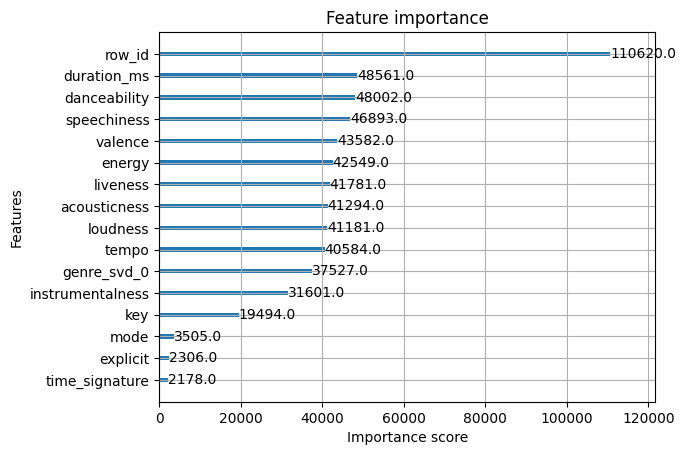

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Train model
model = XGBRegressor(objective="reg:squarederror", n_estimators=10000, n_jobs=-1)
model.fit(X_train, Y_train)

# Plot feature importance
plot_importance(model)
plt.show()

In [5]:
# Make predictions
Y_pred = model.predict(X_test)
print("R^2:", r2_score(Y_test, Y_pred))

R^2: 0.5519349575042725


In [6]:
# Retrain full model
model.fit(X, Y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
import datetime

# Load test data
data_test = pd.read_csv("data/test_data.csv")

# Prepare test data
X_test = prepare_X(data_test)

# Make predictions
Y_pred = model.predict(X_test)

# Save predictions, index is row_id
Y_pred_df = pd.DataFrame(Y_pred, columns=["popularity"])
Y_pred_df.index = data_test["row_id"]

# Save CSV
filename = "pred/pred_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv"
Y_pred_df.to_csv(filename, index_label="row_id")
